# Naive

This model just repeats the observation from $k$ steps before, i.e. 
$\hat{y}_{t+k} = y_t$.

## 1. Setup

### 1.1 Load data

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from utilities.datatools import create_timestamps

data_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")

price_col = "ELECTRICITY_PRICE"
date_col = "SETTLEMENT_DATE"
period_col = "SETTLEMENT_PERIOD"
time_col = "TIMESTAMP"

df = pd.read_csv(os.path.join(data_dir, "bmrs_data.csv"), parse_dates=[date_col])
df.sort_values([date_col, period_col], inplace=True)
df[time_col] = create_timestamps(df, date_col, period_col, tz="Europe/London")

# Drop unnecessary columns
df = df[[price_col, date_col, period_col, time_col]].copy()

print(f"Loaded {len(df)} observations")
print(f"Date range: {df[date_col].min().date()} to {df[date_col].max().date()}")

Loaded 68208 observations
Date range: 2021-01-01 to 2024-12-31


### 1.2 Define model

In [2]:
class NaiveTimeSeries:
    """Predicts y_p(t+k) to be the same as the actually observed value y(t)."""

    def __init__(self, k: int):
        """Initialise a NaiveTimeSeries instance.
        
        Args:
            k (int): Periodicity of the time series
        """
        self.k = k
        self.endog = None

    def apply(
        self,
        endog: pd.Series,
        exog = None,
        refit = True,
        copy_initialization = True,
        **kwargs
    ):
        """Apply the model to new data.
        
        This just stores the last k observations.
        """
        if refit:
            self.observations = endog.iloc[(-self.k):]
        return self

    def forecast(self, steps: int = 1, exog = None) -> pd.Series:
        """Forecast the next steps values of the time series.
        
        Args:
            steps (int): The number of steps forward to forecast (default: 1)
        """
        obs = self.observations
        k = self.k
        yP = obs.iloc[np.arange(steps) % k]
        return yP

### 1.2 Train-test split

In [3]:
# Train/test split by date
n_train = 48 * 7 * 4  # 4 weeks of training data
n_test = 48  # 1 day

# Train set
df_train = df.iloc[-(n_train + n_test) : -n_test].reset_index(drop=True)
endog_train = df_train[price_col].values

# Test set
df_test = df.iloc[-n_test:].reset_index(drop=True)
df_test.index += len(df_train)
endog_test = df_test[price_col].values

print(f"Training samples: {n_train}")
print(f"Test samples: {n_test}")
print(f"Train date range: {df_train[date_col].min().date()} to {df_train[date_col].max().date()}")
print(f"Test date: {df_test[date_col].iloc[0].date()}")

Training samples: 1344
Test samples: 48
Train date range: 2024-12-03 to 2024-12-30
Test date: 2024-12-31


## 2. Make a simple forecast

### 2.1 Train-test split

In [4]:
endog = df[price_col]

# Train/test split by date
n_train = 48 * 7  # 1 week of training data
n_test = 48 * 2  # 2 days of test data

# Train set (reset index to start from 0)
df_train = df.iloc[-(n_train + n_test) : -n_test].reset_index(drop=True)
endog_train = df_train[price_col]

# Test set (index continues from train set)
df_test = df.iloc[-n_test:].reset_index(drop=True)
df_test.index += len(df_train)
endog_test = df_test[price_col]

### 2.2 Specify model parameters

In [5]:
model = NaiveTimeSeries(k=48)
model_fitted = model.apply(endog_train)

### 2.3 Make forecast

In [6]:
from utilities.evaluation import rmse, mae

forecast = model_fitted.forecast(steps=n_test)

# Compute forecasting error
print(f"RMSE: {rmse(np.asarray(forecast), np.asarray(endog_test)):.2f} £/MWh")
print(f"MAE: {mae(np.asarray(forecast), np.asarray(endog_test)):.2f} £/MWh")

RMSE: 51.45 £/MWh
MAE: 42.79 £/MWh


### 2.4 Visualise results

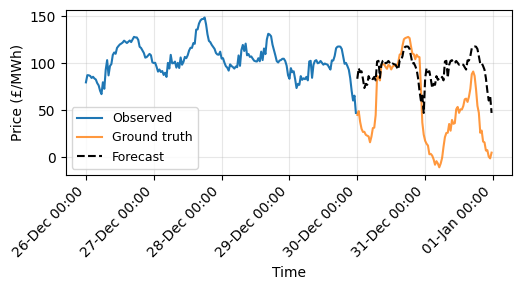

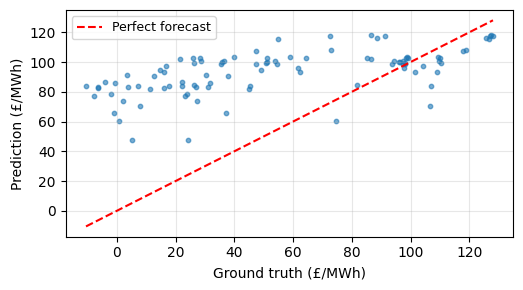

In [7]:
import matplotlib.dates as mdates

# Get data for plotting
train_tail = df_train.iloc[-(2 * n_test):]
test_data = df_test

# Time series plot with timestamps
fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="tight")
ax.plot(train_tail[time_col], train_tail[price_col], label="Observed")
ax.plot(test_data[time_col], test_data[price_col], label="Ground truth", alpha=0.8)
ax.plot(test_data[time_col], forecast, ls="--", color="k", label="Forecast")

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H:%M'))
ax.set_xlabel("Time", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.show()

# Scatter plot with time-of-day color coding
fig, ax = plt.subplots(figsize=(16 / 3, 3), layout="tight")

# Color by settlement period
scatter = ax.scatter(test_data[price_col], forecast, alpha=0.6, s=10)

# Perfect forecast line
ax.plot(
    [test_data[price_col].min(), test_data[price_col].max()],
    [test_data[price_col].min(), test_data[price_col].max()],
    "r--", label="Perfect forecast"
)

ax.set_xlabel("Ground truth (£/MWh)", fontsize=10)
ax.set_ylabel("Prediction (£/MWh)", fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.show()

## 3. Rolling day-ahead forecast evaluation

We now implement a rolling forecast where we:
1. Fit the model on a window of historical data
2. Forecast the prices for the day ahead
4. Update the model with latest observations
5. Move on to the next day and repeat

### 3.1 Setup

In [8]:
import datetime as dt

# Rolling forecast parameters
n_train_samples = 100  # Number of training samples
forecast_days = 7  # Number of day-ahead forecasts to make
issue_period = 18  # Issue forecast at 09:00 (period 18)

print("Rolling forecast configuration:")
print(f"  Training set size: {n_train_samples} samples")
print(f"  Forecast days: {forecast_days}")
print(f"  Issue time: Period {issue_period}")

# Create issue dates
start_date = dt.date(2024, 11, 1)
end_date = start_date + pd.Timedelta(days=forecast_days)
issue_dates = pd.date_range(start_date, end_date, freq="D")

print("\nDates on which forecasts are issued:")
print(f"  First: {issue_dates[0].date()}")
print(f"  Last: {issue_dates[-1].date()}")
print(f"  Total: {len(issue_dates)} days")

# Model specification
k = 48  # Periodicity

print("\nModel specification:")
print(f"  Periodicity: {k}")

Rolling forecast configuration:
  Training set size: 100 samples
  Forecast days: 7
  Issue time: Period 18

Dates on which forecasts are issued:
  First: 2024-11-01
  Last: 2024-11-08
  Total: 8 days

Model specification:
  Periodicity: 48


### 3.2 Forecast

In [9]:
from utilities.forecast import rolling_dayahead_forecast

# Initialise model on first training window
# Find index for first issue date
issue_mask = (df[date_col] == issue_dates[0]) & (df[period_col] == issue_period)
issue_idx = df[issue_mask].index[0]

# Get initial training window
train_start = issue_idx - n_train_samples
train_end = issue_idx

# Extract training data
train_df = df.iloc[train_start:train_end]
train_endog = train_df[price_col]

# Create and fit initial model
model = NaiveTimeSeries(k)
fitted_model = model.apply(train_endog)

print(f"Model initialised on {len(train_endog)} samples")

print("Running rolling forecast...")
results = rolling_dayahead_forecast(
    fitted_model,
    df,
    issue_dates,
    issue_period,
    n_train_samples,
    endog_col=price_col,
    date_col=date_col,
    period_col=period_col,
    seed=0,
    verbose=True,
)

# Summary statistics
rmse_val = np.sqrt(np.mean((results["forecast"] - results["actual"]) ** 2))

print("\n" + "=" * 50)
print("RESULTS SUMMARY")
print("=" * 50)
print(f"Total forecasts: {len(results)} periods")
print(f"RMSE: {rmse_val:.2f} £/MWh")

Model initialised on 100 samples
Running rolling forecast...
[1/8] Forecasting from 2024-11-01 00:00:00
  RMSE: 9.73, MAE: 7.48
[2/8] Forecasting from 2024-11-02 00:00:00
  RMSE: 7.21, MAE: 5.61
[3/8] Forecasting from 2024-11-03 00:00:00
  RMSE: 21.49, MAE: 14.53
[4/8] Forecasting from 2024-11-04 00:00:00
  RMSE: 27.38, MAE: 18.32
[5/8] Forecasting from 2024-11-05 00:00:00
  RMSE: 13.48, MAE: 9.76
[6/8] Forecasting from 2024-11-06 00:00:00
  RMSE: 32.36, MAE: 25.39
[7/8] Forecasting from 2024-11-07 00:00:00
  RMSE: 16.38, MAE: 13.09
[8/8] Forecasting from 2024-11-08 00:00:00
  RMSE: 12.56, MAE: 10.20

RESULTS SUMMARY
Total forecasts: 384 periods
RMSE: 19.41 £/MWh


### 3.3 Results

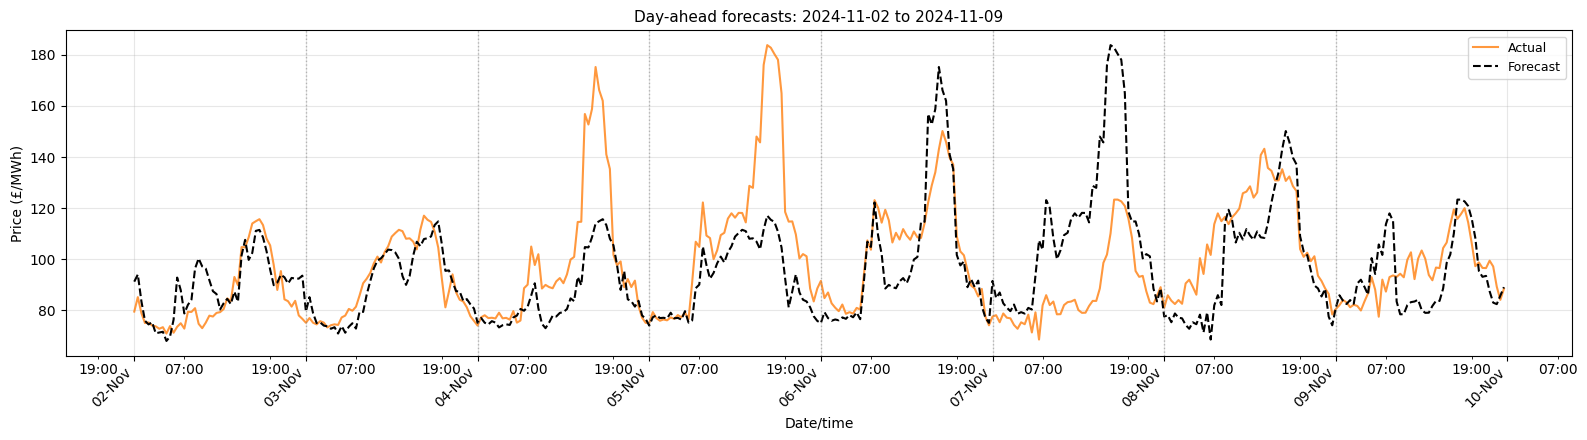

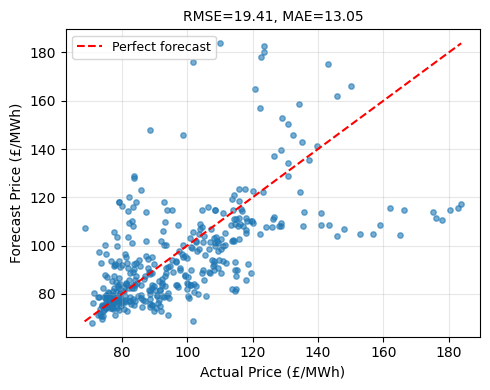

In [11]:
from utilities.evaluation import mae, rmse
import matplotlib.dates as mdates
from utilities.datatools import create_timestamps

# Create timestamps for results
results[time_col] = create_timestamps(
    results,
    date_column=date_col,
    period_column=period_col,
    tz="Europe/London"
)

# Main time series plot with day boundaries
fig, ax = plt.subplots(figsize=(16, 9 / 2), layout="tight")

ts = results[time_col]
ax.plot(ts, results["actual"], "C1", label="Actual", linewidth=1.5, alpha=0.8)
ax.plot(ts, results["forecast"], "k--", label="Forecast", linewidth=1.5)

# Add vertical lines at midnight (day boundaries)
unique_dates = results[date_col].unique()
for date in unique_dates[1:]:  # Skip first day
    midnight = pd.Timestamp(date, tz="Europe/London")
    ax.axvline(midnight, color="gray", linestyle=":", alpha=0.5, linewidth=1)

# Format x-axis to show dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=12))

# Labels and title
date_range = f"{unique_dates[0].date()} to {unique_dates[-1].date()}"
ax.set_xlabel("Date/time", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.set_title(f"Day-ahead forecasts: {date_range}", fontsize=11)
ax.legend(fontsize=9, loc="best")
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha='right')
plt.show()

# Scatter plot
fig, ax = plt.subplots(figsize=(5, 4), layout="tight")
scatter = ax.scatter(results["actual"], results["forecast"], alpha=0.6, s=15)
ax.plot(
    [results["actual"].min(), results["actual"].max()],
    [results["actual"].min(), results["actual"].max()],
    "r--", label="Perfect forecast", linewidth=1.5
)

y_pred = np.asarray(results["forecast"])
y_true = np.asarray(results["actual"])
_rmse = rmse(y_pred, y_true)
_mae = mae(y_pred, y_true)
ax.set_xlabel("Actual Price (£/MWh)", fontsize=10)
ax.set_ylabel("Forecast Price (£/MWh)", fontsize=10)
ax.set_title(f"RMSE={_rmse:.2f}, MAE={_mae:.2f}", fontsize=10)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.show()